### RTL-SDR

Ha muchos SDR de proposistos generales disponibles comercialmente, tanto para el receptor como para el receptor/transceptor, pero son bastante caros en general (> 100 u$d para RX y> 300 u$d para RX/TX). 
Aquí es donde entran en juego los dongles USB con sintonizador de TV DVB-T basados en el chipset RTL2832U. 
Estos dongles son baratos (10 ~ 20 u$d) estaban destinados a recibir TV DVB-T, pero los controladores pirateados de Osmocom pueden convertirlos en receptores SDR de banda ancha solamente. 
Por lo tanto, este SDR barato se conoce generalmente como RTL-SDR:

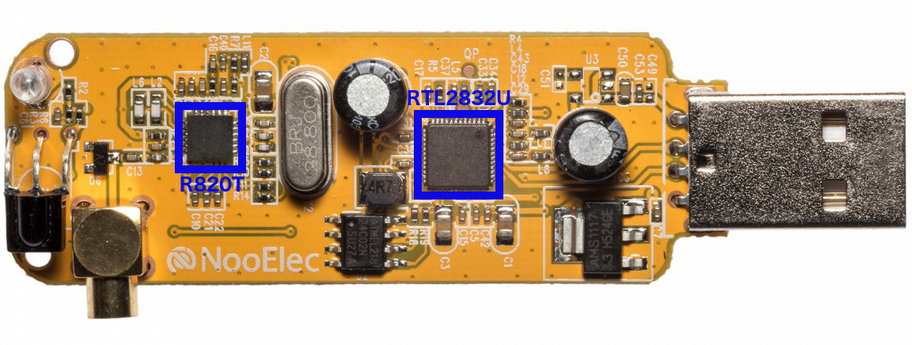

Este tiene un conector de antena MCX estándar y viene con una pequeña antena de látigo.

El diagrama del circuito de la fotografia se muestra a continuación:

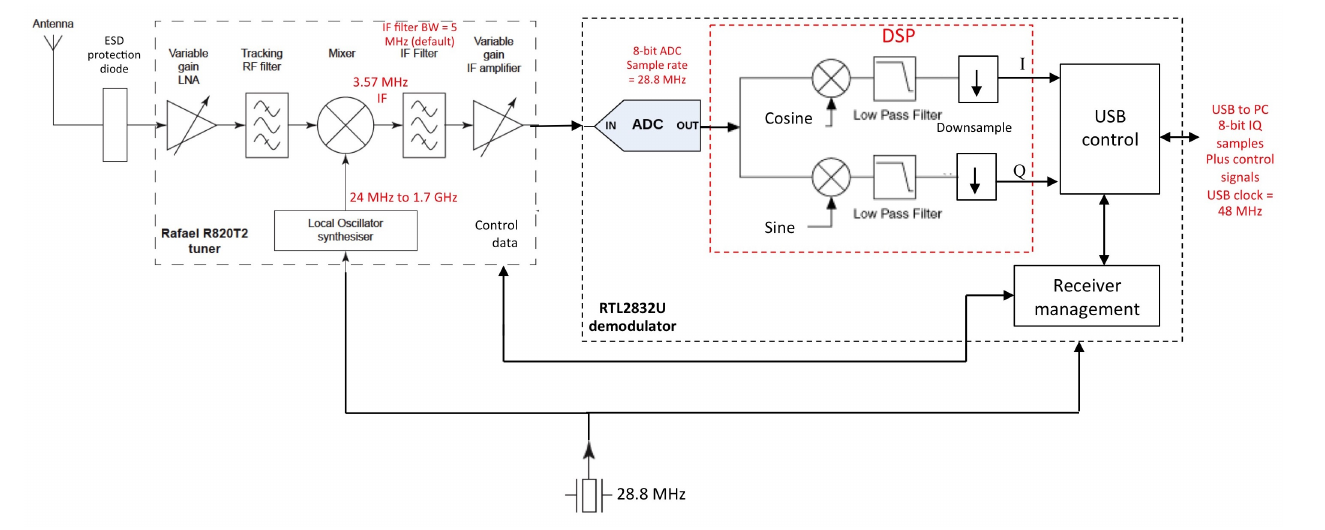

## Los dongles USB para TV DVB-T basados en RTL2832U

La arquitectura general de los dongles RTL-SDR se basa en un receptor superheterodino que es un diseño popular para los receptores que deben poder procesar señales en una amplia gama de frecuencias seleccionadas por el usuario, aislando A partir de otras señales y amplificarlas. Algunos ejemplos son muchos receptores de radio AM/FM convencionales en los que el usuario selecciona un canal sintonizando la radio a su frecuencia de onda portadora.
Se debe aplicar un filtro lo suficientemente selectivo a la señal que proviene de la antena para filtrar otras señales y ruidos fuera de la banda de interés antes de la demodulación. Para el propósito descrito anteriormente, también debe tener una frecuencia central ajustable que hace que su implementación práctica sea problemática. Las arquitecturas superheterodinas resuelven esto convirtiendo primero a una frecuencia intermedia (IF) en la que se pueden aplicar etapas de filtrado y amplificación más rigurosas ahora que la señal está en una frecuencia preestablecida fija (ver la figura a continuación para una configuración típica).

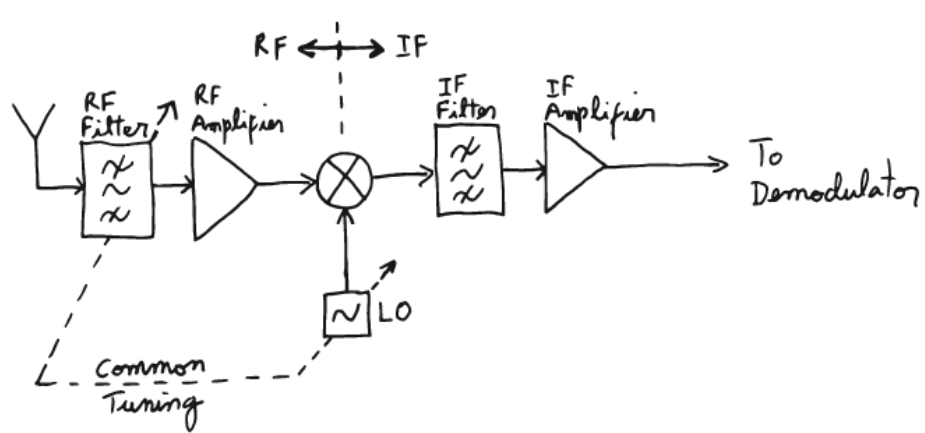

Esta conversión descendente se logra mezclando con una onda sinusoidal de la frecuencia apropiada generada por un oscilador local (LO). Cuando el usuario selecciona una frecuencia fcfc para sintonizar, el LO genera una onda sinusoidal en $f_{LO}=f_c-f_{IF}$,  $f_{LO} = f_c - f_{IF}$ (inyección en el lado bajo) o $f_{LO}=f_c+f_{IF}$,  $f_{LO} = f_c + f_{IF}$ (alto) inyección lateral, tenga en cuenta que cuando utilice esta frecuencia, el espectro de la señal resultante se invertirá en frecuencia). Un subproducto de esta mezcla es que tanto fcfc como fc∓2fIFfc∓2fIF (para inyección lateral alta / baja respectivamente) se mezclan en la frecuencia intermedia. La primera es la frecuencia de interés y la otra es la llamada frecuencia de imagen.

Por lo tanto, una etapa inicial de filtrado de radiofrecuencia (RF) es útil para filtrar cualquier señal o ruido en esta frecuencia de imagen. Este filtro de RF a menudo tiene una frecuencia central variable cuya afinación se comparte con el LO. Otro componente común de la sección de RF del receptor es un amplificador, a menudo llamado amplificador de bajo ruido (LNA).

Si bien tradicionalmente la sección de procesamiento de señal de frecuencia intermedia era analógica, últimamente, debido a la ubicuidad de los circuitos integrados y la disponibilidad de microprocesadores en muchos dispositivos (como teléfonos celulares), la tendencia ha sido manejar algunas de estas tareas digitalmente. En este caso, las arquitecturas superheterodinas son útiles ya que convierten una señal de banda de paso que es demasiado poco práctica para muestrear (debido a que su alta frecuencia requiere frecuencias de muestreo muy altas) a una señal de banda de paso de frecuencia más baja que es más manejable muestrear sin alias.

En los dongles RTL-SDR, la señal se muestrea a una frecuencia intermedia baja después de una etapa de filtrado y amplificación analógica y se procesa digitalmente. Los dongles RTL-SDR contienen 2 circuitos integrados (IC) importantes que implementan las diferentes funciones del receptor superheterodino:
    Sintonizador: el extremo frontal de RF que implementa la parte de procesamiento de señal analógica del receptor y es responsable de la conversión descendente en la frecuencia intermedia; 
    RTL2832U: toma muestras de la señal y realiza tareas adicionales de procesamiento de señales digitales, como la decimación. También maneja control USB. 


En las siguientes secciones se detallará la función de cada uno de estos componentes importantes. La información de estas secciones se recopila de varias fuentes, incluido el código fuente del controlador Osmocom. 
El sitio web de Superkuh merece una mención especial, ya que es una verdadera cala del tesoro para cualquier cosa relacionada con RTL-SDR.

### Sintonizador

Existen dos familias principales de chips de sintonizador de interés para las aplicaciones de SDR, el ahora descontinuado Elonics E4000 y el sintonizador de radio Raphael Micro R820T / R820T2, que será el tema central de esta discusión. Las diferencias entre la T y la T2 son pequeñas, esencialmente equivalentes a una sensibilidad ligeramente mejor¹ para propósitos prácticos.
La hojadatos dedel R820T se filtró en línea, por lo que se sabe mucho sobre el funcionamiento interno de este chip. Tambiénuna descripción de registro está disponiblepara el R820T2 que detalla los parámetros del sintonizador que se pueden configurar desde el exterior. A continuación se muestra un diagrama simplificado de alto nivel basado en el que se encuentra en la hoja de datos:

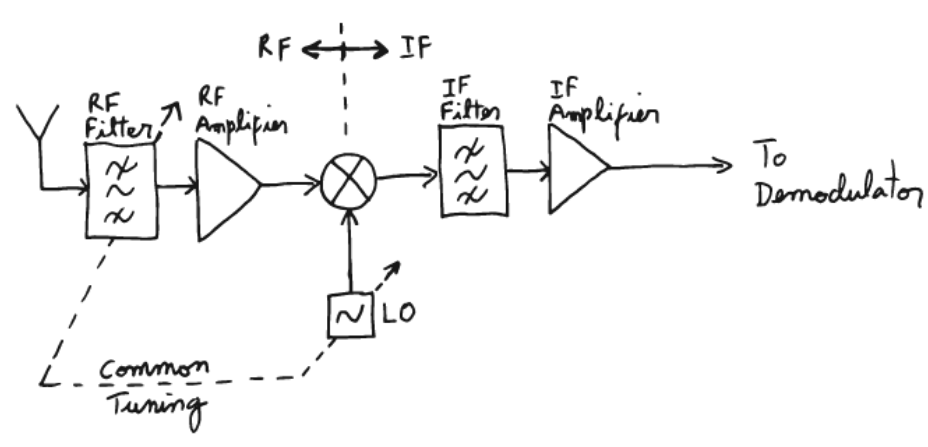

La señal que proviene del conector de la antena primero pasa por un amplificador de bajo ruido (LNA) y luego se filtra mediante un filtro de paso de banda y un filtro de rechazo de imagen. Según la hoja de datos, el rechazo de la imagen es de 65 dBc.

Un sintetizador de frecuencia basado en PLL fraccional genera el LO que se mezcla con esta señal filtrada para convertirlo a una frecuencia intermedia baja. El usuario controla la frecuencia del oscilador local directamente a través de los parámetros del sintetizador de frecuencia. Esto establece de manera indirecta la frecuencia de FI y si se usa inyección de lado alto o bajo. 3.57 MHz y 4.57 MHz son valores típicos para el IF de los dongles R820T¹ pero esencialmente depende de la implementación del controlador elegir qué valores usar (sujeto a los límites impuestos por los parámetros del sintetizador y el filtro de IF). 

El rango de frecuencia que el RTL-SDR puede sintonizar está determinado por el rango de frecuencias que puede generar el sintetizador de frecuencia dentro del chip. El rango oficial del R820T encontrado en la hoja de datos es [42; 1002] MHz con una resolución de sintonización de 1 Hz, pero el rango real generalmente acordado es [24; 1766] MHz¹ según lo determinado por la comunidad RTL-SDR. De hecho, utilizando un conjunto experimental de controladores, este rango de frecuencia se ha extendido hasta [13; 1864] MHz con el límite superior que tiene cierta variabilidad dependiendo de la mochila utilizada.

Finalmente, una vez en la frecuencia intermedia, la señal se filtra de nuevo y pasa por un amplificador de ganancia variable (VGA). El filtro de IF suele ser más selectivo que el RF, ya que ese es el punto de las arquitecturas superheterodinas. En el caso del R820T, está compuesto por un filtro de paso bajo y uno de paso alto que puede configurarse para tener un ancho de banda tan bajo como 300 kHz². Sin embargo, sus "valores estándar" son 6, 7 u 8 MHz, ya que estos son los anchos de banda utilizados por las señales DVB-T. 
Hay 3 ganancias generales en el sintonizador que pueden controlarse a través de la configuración externa: el LNA, el mezclador y el VGA. Estas ganancias se pueden establecer manualmente, aunque sus valores precisos están ausentes de la hoja de datos. También se pueden configurar automáticamente a través del control automático de ganancia (AGC) para optimizar la relación señal a ruido (SNR). El LNA y el mezclador tienen un detector de potencia en sus salidas que se utiliza para controlar sus ganancias respectivas para este propósito. El VGA AGC se controla realmente a través de un puerto de entrada analógica al sintonizador que está conectado a un detector de alimentación en el RTL2832U.

Una nota en los chips E4000 es que estos utilizan un IF de 0 Hz, por lo que en realidad no están implementando receptores superheterodinos. Esto tiene una consecuencia notable de producir un pico de CC a 0 Hz.

### RTL2832U
Este es el IC que da el nombre al dongle RTL-SDR. A diferencia del sintonizador, las hojas de datos no están disponibles gratuitamente en línea (deberá firmar una NDA para obtenerla). Por lo tanto, mucho de lo que se sabe sobre el funcionamiento interno de este chip ha sido resuelto por la comunidad RTL-SDR a través de ingeniería inversa. 
Lade Realtek descripción RTL2832U establece que el chip está diseñado como un demodulador DVB-T de alto rendimiento (con soporte adicional para FM y radio DAB). Como tal, incluye un ADC para muestrear la señal de IF proveniente de un sintonizador apropiado, todo el DSP especializado requerido para demodular DVB-T y un controlador USB compatible con una interfaz USB 2.0. El uso como SDR aprovecha el modo de "depuración" en el chip para entregar las muestras de representación de banda base digital compleja directamente a través de USB.
El siguiente diagrama de alto nivel representa mi mejor comprensión de las funciones que está realizando el RTL2832U cuando se usa un IF que no es cero:

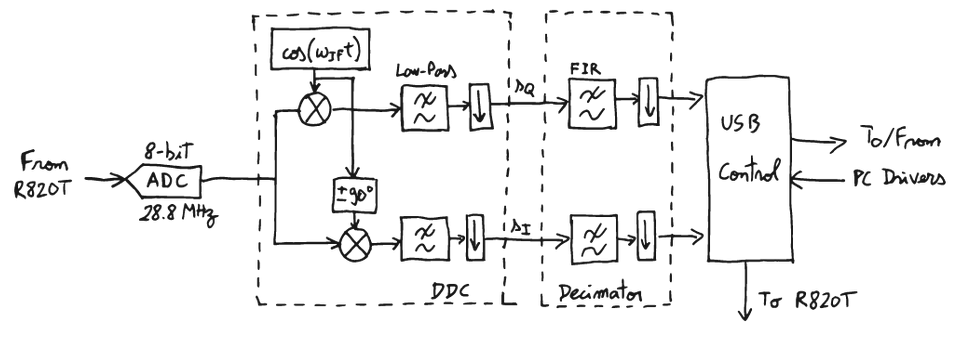

Inicialmente, la señal que sale del sintonizador se muestrea mediante un ADC de 8 bits que funciona a 28,8 MHz. No debe ocurrir un aliasing significativo para los valores bajos de IF admitidos si el filtro de IF es lo suficientemente selectivo como para eliminar cualquier señal fuerte fuera de su ancho de banda.

Un convertidor descendente digital (DDC) es responsable de convertir la señal digital a banda base compleja. El proceso de obtención de la representación de banda base compleja es similar al caso de tiempo continuo: la mezcla con una sinusoide compleja desplazará circularmente el espectro de IF a banda base. Luego, la señal puede filtrarse por un paso bajo y extraerse el muestreo para eliminar la parte innecesaria del espectro que se cambió a frecuencias más altas, ya que la señal de interés ahora está limitada por la banda por una frecuencia más baja. Los parámetros de configuración externa informan al DDC de la frecuencia IF y si el espectro está invertido (es decir, si el sintonizador es una inyección de lado alto).

Finalmente, se aplica la reducción (utilizando un filtro de paso bajo FIR y un submuestreo) para reducir la frecuencia de muestreo de la señal a un valor en el rango [225001; 300000] Hz ∪ [900001; 3200000] Hz. Sin embargo, 2,56 MHz es la frecuencia de muestreo segura más alta generalmente acordada donde el chip no deja caer ninguna muestra (el USB aún puede dejarla caer). Esta decimación es lo que generalmente establece el límite superior en el ancho de banda de la señal muestreada (a menos que el ancho de banda del filtro IF se elija específicamente como más bajo que la frecuencia de Nyquist para la frecuencia de muestreo).

Las muestras de banda base complejas I y Q se envían a través de USB como enteros sin signo de 8 bits entrelazados.

